In [2]:
import pandas as pd
import numpy as np

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestRegressor
from dask_ml.model_selection import GridSearchCV
from dask.diagnostics import ProgressBar

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
import joblib  # 모델 저장용
import webbrowser

from model_class import Models


### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [3]:
wildfire = pd.read_csv("./USA data/final_wildfire_adjusted.csv")
wildfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900596 entries, 0 to 900595
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               900596 non-null  float64
 1   longitude              900596 non-null  float64
 2   brightness             900596 non-null  float64
 3   bright_t31             900596 non-null  float64
 4   frp                    900596 non-null  float64
 5   T2M                    900596 non-null  float64
 6   WS2M                   900596 non-null  float64
 7   RH2M                   900596 non-null  float64
 8   PRECTOTCORR            900596 non-null  float64
 9   confidence_h           900596 non-null  float64
 10  confidence_l           900596 non-null  float64
 11  confidence_n           900596 non-null  float64
 12  daynight_D             900596 non-null  float64
 13  daynight_N             900596 non-null  float64
 14  year                   900596 non-nu

In [4]:
# 데이터를 병합 하며 결측치가 생겨 결측값 제거
wildfire = wildfire.dropna()

# 독립 변수(X): float64 타입만 추출, predicted_area_km2 제외
numeric_columns = wildfire.select_dtypes(include=['float64']).columns
X = wildfire[numeric_columns.drop('predicted_area_km2')]
y = wildfire['predicted_area_km2']

# 스피어만 상관계수 계산
print("스피어만 상관관계 분석 결과 (결측값 제거 후):")
print("-" * 50)

for value in X.columns:
    statistic, pvalue = spearmanr(X[value], y)
    
    # 출력
    if pvalue < 0.05 and abs(statistic) >= 0.2:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)")
    elif pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 약한 상관관계 (유의미)")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하지 않다")

print("-" * 50)

스피어만 상관관계 분석 결과 (결측값 제거 후):
--------------------------------------------------
상관관계 계수 0.047, p-value 0.0000 : (latitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.136, p-value 0.0000 : (longitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.419, p-value 0.0000 : (brightness)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.467, p-value 0.0000 : (bright_t31)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.561, p-value 0.0000 : (frp)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.714, p-value 0.0000 : (T2M)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 -0.140, p-value 0.0000 : (WS2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.781, p-value 0.0000 : (RH2M)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 -0.280, p-value 0.0000 : (PRECTOTCORR)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.250, p-value 0.0000 : (confidence_h)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.157, p-value 0.0000 : (confidence_l)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.303,

In [5]:
train_cols = [
    "frp",           # 강한 상관관계
    "brightness",    # 강한 상관관계
    "bright_t31",    # 강한 상관관계
    "confidence_h",  # 강한 상관관계
    "confidence_l",  # 강한 상관관계
    "confidence_n",  # 강한 상관관계
    "daynight_D",    # 강한 상관관계
    "daynight_N",    # 강한 상관관계
    "latitude",      # 약한 상관관계
    "longitude",     # 약한 상관관계
    "T2M",           # 약한 상관관계
    "WS2M",          # 약한 상관관계
    "RH2M",          # 약한 상관관계
    "PRECTOTCORR",   # 약한 상관관계
    "year",          # 약한 상관관계
    "month",         # 약한 상관관계
    "day",           # 약한 상관관계
    "season",        # 약한 상관관계
    "weekday",       # 약한 상관관계
    "WS2M_RH2M_interaction",  # 약한 상관관계
    "high_temperature",       # 약한 상관관계
    "precipitation_flag"      # 약한 상관관계
]

# 데이터 준비
train = wildfire[train_cols]
target = wildfire["predicted_area_km2"]

# 첫 번째 분할 (훈련 데이터와 검증 데이터)
train_input, val_input, train_target, val_target = train_test_split(train, target, test_size=0.4, random_state=42, shuffle=True)

# 두 번째 분할 (검증 데이터와 테스트 데이터)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target, test_size=0.5, random_state=42, shuffle=True)

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)


(540357, 22) (540357,)
(180119, 22) (180119,)
(180120, 22) (180120,)


In [8]:
# XGBRegressor 설정
xg = XGBRegressor(random_state=42)

# GridSearchCV 하이퍼파라미터 설정 (이전과 동일한 범위)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# GridSearchCV 적용
search = GridSearchCV(
    estimator=xg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

# 모델 학습
search.fit(train_input, train_target)

# 최적 모델 및 파라미터 출력
best_model = search.best_estimator_
print("Best Parameters:", search.best_params_)

# 성능 평가
train_score = best_model.score(train_input, train_target)
val_score = best_model.score(val_input, val_target)
test_score = best_model.score(test_input, test_target)

print(f"train_score: {train_score}, val_score: {val_score}, test_score: {test_score}, 과적합여부: {train_score - val_score}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
train_score: 0.9982054438662918, val_score: 0.9971466615665101, test_score: 0.9971623283526656, 과적합여부: 0.0010587822997817353


In [9]:
models = Models()
models.total_models(train_input, train_target, val_input, val_target, test_input, test_target)

Tuning and training RandomForest with None...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}
-*** RandomForest with None ***-
훈련: 1.0000, 검증: 0.9999, 테스트: 0.9999, 과적합여부: 0.0001
사용 가능한 모델입니다 (일반화).

Saved RandomForest with None as final model.
Tuning and training HistGradientBoosting with None...
Best Parameters for HistGradientBoosting: {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1}
-*** HistGradientBoosting with None ***-
훈련: 0.9971, 검증: 0.9966, 테스트: 0.9967, 과적합여부: 0.0005
사용 가능한 모델입니다 (일반화).

Saved HistGradientBoosting with None as final model.
Tuning and training XGB with None...
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
-*** XGB with None ***-
훈련: 0.9982, 검증: 0.9971, 테스트: 0.9972, 과적합여부: 0.0011
사용 가능한 모델입니다 (일반화).

Saved XGB with None as final model.
Tuning and training RandomForest with Standard...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_sample

In [11]:
results_df = models.get_results()
results_df

,model_nm,Scaler,GSCV,train_score,val_score,test_score,과적합여부,사용,train_mae,train_mse,train_r2,val_mae,val_mse,val_r2,test_mae,test_mse,test_r2
0,RandomForest,None,Y,0.999982,0.999915,0.999909,0.000068,Y,0.002007,0.000032,0.999982,0.003932,0.000151,0.999915,0.003950,0.000163,0.999909
1,HistGradientBoosting,None,Y,0.997143,0.996644,0.996666,0.000499,Y,0.020188,0.005148,0.997143,0.020769,0.005921,0.996644,0.020694,0.005976,0.996666
2,XGB,None,Y,0.998205,0.997147,0.997162,0.001059,Y,0.017499,0.003234,0.998205,0.019054,0.005034,0.997147,0.018923,0.005086,0.997162
3,RandomForest,Standard,Y,0.999982,0.999914,0.999908,0.000068,Y,0.002008,0.000032,0.999982,0.003938,0.000152,0.999914,0.003954,0.000165,0.999908
4,HistGradientBoosting,Standard,Y,0.997143,0.996644,0.996666,0.000499,Y,0.020188,0.005148,0.997143,0.020769,0.005921,0.996644,0.020694,0.005976,0.996666
5,XGB,Standard,Y,0.998211,0.997123,0.997151,0.001088,Y,0.017369,0.003224,0.998211,0.018989,0.005076,0.997123,0.018859,0.005106,0.997151
6,RandomForest,MinMax,Y,0.999982,0.999914,0.999907,0.000068,Y,0.002009,0.000032,0.999982,0.003936,0.000152,0.999914,0.003956,0.000166,0.999907
7,HistGradientBoosting,MinMax,Y,0.997143,0.996644,0.996666,0.000499,Y,0.020188,0.005148,0.997143,0.020769,0.005921,0.996644,0.020694,0.005976,0.996666
8,XGB,MinMax,Y,0.998189,0.997128,0.997172,0.001060,Y,0.017443,0.003264,0.998189,0.019006,0.005067,0.997128,0.018814,0.005068,0.997172
9,RandomForest,Robust,Y,0.999982,0.999914,0.999908,0.000068,Y,0.002008,0.000032,0.999982,0.003933,0.000151,0.999914,0.003953,0.000165,0.999908


In [12]:
results_df.to_csv("model_results_final.csv", index=False)

모델 로드 완료: RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200,
                      random_state=42)


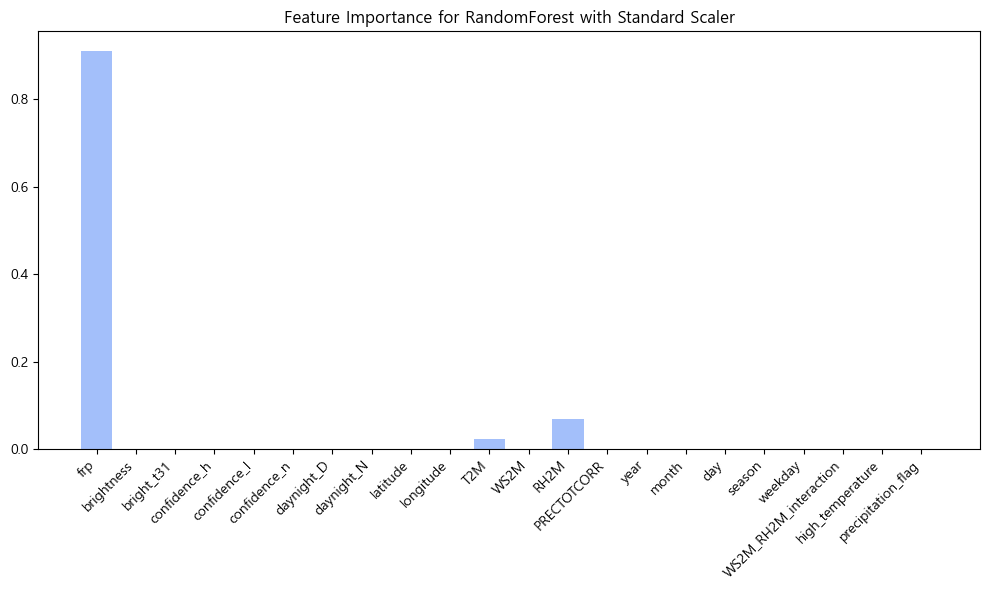

In [14]:
# 모델 로드
model_path = "RandomForest_Standard_final_model.pkl"  # 모델 경로 입력
best_model = joblib.load(model_path)
print("모델 로드 완료:", best_model)

# 데이터 준비
wildfire = pd.read_csv("./USA data/final_wildfire_adjusted.csv")  # CSV 경로

# 학습 때 사용한 22개 피처
train_cols = [
    "frp",           # 강한 상관관계
    "brightness",    # 강한 상관관계
    "bright_t31",    # 강한 상관관계
    "confidence_h",  # 강한 상관관계
    "confidence_l",  # 강한 상관관계
    "confidence_n",  # 강한 상관관계
    "daynight_D",    # 강한 상관관계
    "daynight_N",    # 강한 상관관계
    "latitude",      # 약한 상관관계
    "longitude",     # 약한 상관관계
    "T2M",           # 약한 상관관계
    "WS2M",          # 약한 상관관계
    "RH2M",          # 약한 상관관계
    "PRECTOTCORR",   # 약한 상관관계
    "year",          # 약한 상관관계
    "month",         # 약한 상관관계
    "day",           # 약한 상관관계
    "season",        # 약한 상관관계
    "weekday",       # 약한 상관관계
    "WS2M_RH2M_interaction",  # 약한 상관관계
    "high_temperature",       # 약한 상관관계
    "precipitation_flag"      # 약한 상관관계
]

# 데이터 준비 (테스트 데이터)
test_data = wildfire[train_cols]

# 모델의 feature_importances_ 속성을 사용하여 피처 중요도 계산
feature_names = train_cols
importances = best_model.feature_importances_

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color="#A3BFFA")
plt.title("Feature Importance for RandomForest with Standard Scaler")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# 결과를 이미지로 저장
plt.savefig("feature_importance.png")
plt.show()

In [15]:
# 지도 초기화: 중심 좌표는 샘플로 34.0, -118.0 (미국 캘리포니아 근처)
m = folium.Map(location=[34.0, -118.0], zoom_start=5)

# wildfire 데이터셋에서 100개의 샘플을 선택해서 반복
for idx, row in wildfire.sample(100).iterrows():  # wildfire는 원본 데이터프레임
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],  # 위도, 경도
        radius=max(row["predicted_area_km2"] * 10, 1),  # 예측된 면적을 기준으로 원의 크기 결정 (10배 크기 비율)
        color="#FF0000",  # 원의 테두리 색 (빨간색)
        fill=True,
        fill_color="#FF0000",  # 원 내부 색 (빨간색)
        fill_opacity=0.5,  # 내부 색의 투명도 (50%)
        popup=f"Predicted Area: {row['predicted_area_km2']:.2f} km²"  # 팝업에 표시될 텍스트
    ).add_to(m)

# 지도를 HTML 파일로 저장
m.save("predicted_fire_map.html")
print("지도 재저장 완료.")

지도 재저장 완료.


In [16]:
# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser
